In [11]:
# --- Phase 3: Tuning Function Fitting ---
# Goal: Load the outputs from the previous notebooks (00 & 02) and use them 
# to estimate the receptive field (RF) for each neuron.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import utils as U 
import importlib
import os
import glob

# Reload utils to ensure you're using the latest version of your functions
importlib.reload(U) 

print("Starting Phase 3: Tuning Function Fitting...")

# --- Step 1: Load Inputs from Saved Files ---

try:
    # ACTION: Change 'aakarsh' to your namespace if needed.
    namespace = "aakarsh" 
    
    # --- Load the latest output from the preprocessing notebook (00-background.ipynb) ---
    background_dir = f'data/{namespace}/background/'
    list_of_background_files = glob.glob(os.path.join(background_dir, '*.npz'))
    if not list_of_background_files:
        raise FileNotFoundError(f"No background data files found in '{background_dir}'")
    
    latest_background_file = max(list_of_background_files, key=os.path.getctime)
    print(f"Loading latest background data from: {latest_background_file}")
    
    stim_data = np.load(latest_background_file, allow_pickle=True)
    stim_filtered = stim_data['stim_filtered']
    stim_table_filtered_df = pd.DataFrame(stim_data['stim_table_filtered'], columns=stim_data['stim_table_columns'])
    

    # --- Load the latest output from the spike inference notebook (02-spike-inference.ipynb) ---
    spike_inference_dir = f'data/{namespace}/preprocessed/'
    list_of_spike_files = glob.glob(os.path.join(spike_inference_dir, '*.npz'))
    if not list_of_spike_files:
        raise FileNotFoundError(f"No spike inference files found in '{spike_inference_dir}'")
    
    latest_spike_file = max(list_of_spike_files, key=os.path.getctime)
    print(f"Loading latest spike inference data from: {latest_spike_file}")
    
    spike_data = np.load(latest_spike_file, allow_pickle=True)
    print(spike_data.keys())

    inferred_spikes = spike_data['spike_counts']
    time_vector = spike_data['time_vector']
    sampling_rate = spike_data['sampling_frequency']
   
    data  = U.load_data()# Load the latest spike inference data
    data  = U.preprocess_data(data)  # Preprocess the data 

except FileNotFoundError as e:
    print(f"ERROR: Could not find a necessary input file: {e}")
    print("Please ensure you have run the previous notebooks (00 and 02) and saved their outputs correctly.")
    raise

Starting Phase 3: Tuning Function Fitting...
Loading latest background data from: data/aakarsh/background/cleaned_2025_07_16_17_35_52.npz
Loading latest spike inference data from: data/aakarsh/preprocessed/oasis_preprocessed_recordings_2025_07_18_10_16_01.npz
KeysView(NpzFile 'data/aakarsh/preprocessed/oasis_preprocessed_recordings_2025_07_18_10_16_01.npz' with keys: processed_neuron_signal, spike_counts, thresholds, sampling_frequency, time_vector)
Performing initial data preprocessing...
Preprocessing complete.


In [12]:
active_stim_per_timestep = U.get_active_stimulus_per_timestep(data['stim_table'], total_timesteps=len(data['t']))

Mapping active stimulus frame to each timestep...
Mapping complete.


In [13]:
importlib.reload(U)  # Reload utils to ensure you're using the latest version of your functions
inferred_spikes = spike_data['spike_counts']
# binned_spikes.shape, presented_frame_ids.shape
binned_spikes, presented_frame_ids =  inferred_spikes, active_stim_per_timestep # stimulus data is already binned. 
#\ U.bin_spikes_to_frames_from_active_stim_per_timestep(inferred_spikes, active_stim_per_timestep)

In [14]:
# Filter presented frame_ids and binned spikes by removing indexes where presented_Frame_ids is -1
binned_spikes = binned_spikes[:, presented_frame_ids != -1]
presented_frame_ids = presented_frame_ids[presented_frame_ids != -1]
print(f"binned_spikes.shape: {binned_spikes.shape}, presented_frame_ids.shape: {presented_frame_ids.shape}")

binned_spikes.shape: (189, 62521), presented_frame_ids.shape: (62521,)


In [15]:
assert np.sum(presented_frame_ids[presented_frame_ids == -1]) == 0, "There are still -1 values in presented_frame_ids. Please check the filtering step."

In [16]:
# Prepare the stimulus matrix from the presented frame IDs
importlib.reload(U)  # Reload utils to ensure you're using the latest version of your functions

flattened_stim, stim_h, stim_w = \
    U.prepare_stimulus_matrix_from_ids(presented_frame_ids, full_stim_movie=data['stim'])

Preparing stimulus matrix from frame IDs...
Stimulus matrix preparation complete. Shape: (448, 62521)


In [17]:
# Convert the stimulus to binary matrices for 'ON' and 'OFF' stimuli, these are easier to train and give better receptive field estimates.

# Create a copy of the original flattened stimulus matrix
flattened_on_stimuli = flattened_stim.copy()
flattened_off_stimuli = flattened_stim.copy()

# For the 'ON' matrix, set all 'OFF' pixels (<= 127) to zero
flattened_on_stimuli[flattened_on_stimuli <= 127] = 0
flattened_on_stimuli[flattened_on_stimuli > 127] = 1

# For the 'OFF' matrix, set all 'ON' pixels (> 127) to zero
flattened_off_stimuli[flattened_off_stimuli < 127] = 1
flattened_off_stimuli[flattened_off_stimuli >= 127] = 0

# --- Verification ---
print(f"Flattened Stimulus Shape: {flattened_stim.shape}")
print(f"Flattened On Stimuli Shape: {flattened_on_stimuli.shape}")
print(f"Flattened Off Stimuli Shape: {flattened_off_stimuli.shape}")

# These assertions will now pass because the shape is preserved
assert flattened_on_stimuli.shape == flattened_stim.shape, "The shape of flattened_on_stimuli does not match the shape of flattened_stim."
assert flattened_off_stimuli.shape == flattened_stim.shape, "The shape of flattened_off_stimuli does not match the shape of flattened_stim."

print("\nAssertions passed! The shapes are now correct.")

Flattened Stimulus Shape: (448, 62521)
Flattened On Stimuli Shape: (448, 62521)
Flattened Off Stimuli Shape: (448, 62521)

Assertions passed! The shapes are now correct.


In [18]:
print(flattened_off_stimuli.shape)

(448, 62521)


In [20]:
from scipy.special import gammaln


def negloglike_lnp(
    w: np.array, c: np.array, s: np.array, dt: float = 0.1, R: float = 50
) -> float:
    """Implements the negative (!) log-likelihood of the LNP model

    Parameters
    ----------

    w: np.array, (Dx * Dy, )
      current receptive field

    c: np.array, (nT, )
      spike counts

    s: np.array, (Dx * Dy, nT)
      stimulus matrix


    Returns
    -------

    f: float
      function value of the negative log likelihood at w

    """

    # ------------------------------------------------
    # Implement the negative log-likelihood of the LNP
    # ------------------------------------------------

    w = w.ravel()  # ensure shape (D,)
    lin = w @ s  # shape (nT,)
    rates = np.exp(lin) * dt * R  # shape (nT,)

    # term1: ∑ c_t · (w^T s_t)
    term1 = np.dot(c, lin)

    # term2: ∑ exp(w^T s_t) · (Δt·R)
    term2 = rates.sum()

    # term3: ∑ log(c_t!) = ∑ gam    # --- Lmaln(c_t + 1)
    c = np.asarray(c, dtype=np.float64)

    term3 = gammaln(c + 1).sum()

    # term4: ∑ c_t · log(Δt·R)
    log_dtR = np.log(dt * R)
    term4 = (c * log_dtR).sum()

    # full log-likelihood
    logL = term1 - term2 - term3 + term4

    # return *negative* log-likelihood
    return -logL


def deriv_negloglike_lnp(
    w: np.array, c: np.array, s: np.array, dt: float = 0.1, R: float = 50
) -> np.array:
    """
    Implements the gradient of the negative log-likelihood of the LNP model

    Parameters
    ----------

    see negloglike_lnp

    Returns
    -------

    df: np.array, (Dx * Dy, )
      gradient of the negative log likelihood with respect to w
    """
    w = w.ravel()  # ensure shape (D*D,)
    lin = w @ s  # shape (nT,)
    rates = np.exp(lin) * dt * R

    # gradient = ∑_t (r_t - c_t) s_t
    grad = s @ (rates - c)  # shape (D*D,)
    return grad

def negloglike_lnp_l1(
    w: np.array, c: np.array, s: np.array, dt: float = 0.1, R: float = 50, lambda_l1: float = 1e-3
) -> float:
    negloglike = negloglike_lnp(w, c, s, dt, R)
    l1_penalty = lambda_l1 * np.sum(np.abs(w))
    return negloglike + l1_penalty


def deriv_negloglike_lnp_l1(
    w: np.array, c: np.array, s: np.array, dt: float = 0.1, R: float = 50, lambda_l1: float = 1e-3
) -> np.array:
    grad = deriv_negloglike_lnp(w, c, s, dt, R)
    # Gradient of L1 norm is sign(w), subgradient at 0 can be taken as 0 or ±1; here we use sign(w)
    grad += lambda_l1 * np.sign(w)
    return grad



In [21]:
import numpy as np
from scipy.optimize import minimize

def build_lagged_stimulus_matrix(flattened_stim, n_lags):
    """
    flattened_stim: shape (num_pixels, num_timepoints)
    n_lags: number of time lags to include
    
    Returns:
      lagged_stim: shape (num_pixels * n_lags, num_timepoints - n_lags + 1)
    """
    num_pixels, num_timepoints = flattened_stim.shape
    lagged_stim = []

    for lag in range(n_lags):
        lagged_stim.append(flattened_stim[:, lag:num_timepoints - (n_lags - lag - 1)])

    return np.vstack(lagged_stim)

# Parameters for lag and LNP model
n_lags = 3   # number of temporal lags to include, tune as you want
dt = 1     # time bin size, adjust if needed
R = 1       # max firing rate, adjust if needed

# Assume you already have these from previous steps
# binned_spikes: shape (num_neurons, num_timepoints)
# flattened_on_stimuli: shape (num_pixels, num_timepoints)

num_neurons = binned_spikes.shape[0]
num_pixels = flattened_on_stimuli.shape[0]

# Build lagged stimulus matrix
lagged_stimuli = build_lagged_stimulus_matrix(flattened_on_stimuli, n_lags)

# New number of time points after lagging
num_timepoints_lagged = lagged_stimuli.shape[1]

receptive_fields = np.zeros((num_neurons, num_pixels * n_lags))

for neuron_idx in range(num_neurons):
    print(f"Fitting RF for neuron {neuron_idx + 1}/{num_neurons}...")

    # Trim spike counts to match lagged stimulus time dimension
    c = binned_spikes[neuron_idx, n_lags - 1 : n_lags - 1 + num_timepoints_lagged]

    # Initialize weights (receptive field) vector for this neuron
    w0 = np.zeros(num_pixels * n_lags)

    # Run optimization to minimize negative log-likelihood
    from tqdm import tqdm

    max_iters = 500
    pbar = tqdm(total=max_iters, desc="Optimizing LNP")

    # Define a callback function to update tqdm
    def callbackF(xk):
        pbar.update(1)

    result = minimize(
        fun=negloglike_lnp,
        x0=w0,
        args=(c, lagged_stimuli, dt, R),
        jac=deriv_negloglike_lnp,
        method='L-BFGS-B',
        callback=callbackF,
        options={'maxiter': max_iters, 'disp': True}
    )

    pbar.close()


    if result.success:
        receptive_fields[neuron_idx, :] = result.x
    else:
        print(f"Optimization failed for neuron {neuron_idx}: {result.message}")

print("Done fitting receptive fields with lag!")


Fitting RF for neuron 1/189...


Optimizing LNP:  10%|█         | 50/500 [02:19<20:55,  2.79s/it]

KeyboardInterrupt: 

In [29]:
neuron_idx = 31  # neuron 32 in zero-based indexing
n_lags = 10

# Build lagged stimulus matrix if you haven't already
lagged_stimuli = build_lagged_stimulus_matrix(flattened_on_stimuli, n_lags)

num_timepoints_lagged = lagged_stimuli.shape[1]
num_pixels = flattened_on_stimuli.shape[0]

# Trim spike counts for this neuron to match lagged stimulus length
c = binned_spikes[neuron_idx, n_lags - 1 : n_lags - 1 + num_timepoints_lagged]

# Initialize receptive field vector
w0 = np.zeros(num_pixels * n_lags)

from tqdm import tqdm

max_iters = 500
pbar = tqdm(total=max_iters, desc="Optimizing LNP")

# Define a callback function to update tqdm
def callbackF(xk):
    pbar.update(1)

result = minimize(
    fun=negloglike_lnp,
    x0=w0,
    args=(c, lagged_stimuli, dt, R),
    jac=deriv_negloglike_lnp,
    method='L-BFGS-B',
    callback=callbackF,
    options={'maxiter': max_iters, 'disp': True}
)

pbar.close()


if result.success:
    rf_neuron_32 = result.x
    print("Neuron 32 receptive field fitted successfully!")
else:
    print(f"Optimization failed for neuron 32: {result.message}")


Optimizing LNP:   0%|          | 0/500 [00:20<?, ?it/s]


Optimizing LNP:  31%|███       | 155/500 [18:10<40:27,  7.04s/it] 

Neuron 32 receptive field fitted successfully!


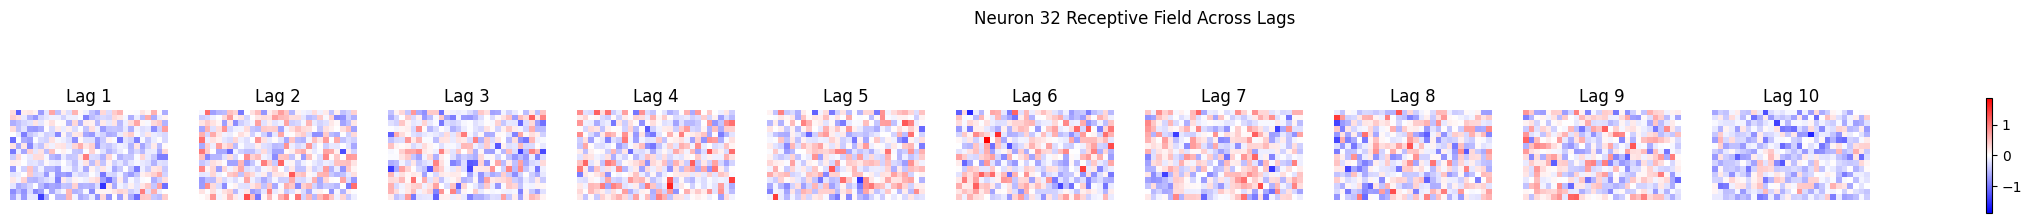

In [30]:
import matplotlib.pyplot as plt

# Assuming you have stim_h and stim_w from your earlier stimulus prep
# For example:
# stim_h, stim_w = height and width of the stimulus frame

# Reshape the RF vector into (n_lags, stim_h, stim_w)
rf_reshaped = rf_neuron_32.reshape(n_lags, stim_h, stim_w)

# Plot each temporal lag as a separate subplot
fig, axes = plt.subplots(1, n_lags, figsize=(3 * n_lags, 3))

for lag in range(n_lags):
    ax = axes[lag]
    im = ax.imshow(rf_reshaped[lag], cmap='bwr', vmin=-np.max(np.abs(rf_reshaped)), vmax=np.max(np.abs(rf_reshaped)))
    ax.set_title(f'Lag {lag+1}')
    ax.axis('off')

fig.suptitle('Neuron 32 Receptive Field Across Lags')
plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)
plt.show()


In [31]:
from scipy.optimize import minimize

neuron_idx = 31  # zero-indexed for neuron 32
c = binned_spikes[neuron_idx, n_lags - 1 : n_lags - 1 + lagged_stimuli.shape[1]]
w0 = np.zeros(lagged_stimuli.shape[0])
lambda_l1 = 1  # tune this!


pbar = tqdm(total=500, desc='Optimization Progress')  # maxiter = 500

def callbackF(xk):
    pbar.update(1)
    # You can also print current loss or norm if you want here
    # e.g.
    # current_loss = negloglike_lnp_l1(xk, c, lagged_stimuli, dt, R, lambda_l1)
    # pbar.set_postfix(loss=current_loss)


result = minimize(
    fun=negloglike_lnp_l1,
    x0=w0,
    args=(c, lagged_stimuli, dt, R, lambda_l1),
    jac=deriv_negloglike_lnp_l1,
    method='L-BFGS-B',
    callback=callbackF,
    options={'maxiter': 500, 'disp': True}
)

if result.success:
    receptive_field_l1 = result.x
    print("L1-regularized RF fitted!")
else:
    print(f"Optimization failed: {result.message}")


Optimization Progress: 100%|██████████| 500/500 [51:12<00:00,  6.01s/it]

Optimization failed: STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT


In [34]:
import matplotlib.pyplot as plt

# Assuming you have stim_h and stim_w from your earlier stimulus prep
# For example:
# stim_h, stim_w = height and width of the stimulus frame

# Reshape the RF vector into (n_lags, stim_h, stim_w)
rf_reshaped = receptive_field_l1.reshape(n_lags, stim_h, stim_w)

# Plot each temporal lag as a separate subplot
fig, axes = plt.subplots(1, n_lags, figsize=(3 * n_lags, 3))

for lag in range(n_lags):
    ax = axes[lag]
    im = ax.imshow(rf_reshaped[lag], cmap='bwr', vmin=-np.max(np.abs(rf_reshaped)), vmax=np.max(np.abs(rf_reshaped)))
    ax.set_title(f'Lag {lag+1}')
    ax.axis('off')

fig.suptitle('Neuron 32 Receptive Field Across Lags')
plt.colorbar(im, ax=axes.ravel().tolist(), shrink=0.5)
plt.show()


ValueError: cannot reshape array of size 1344 into shape (10,16,28)